# HapkeRT

This is a python package designed to perform Hapke radiative transfer modelling for planetary surfaces.

### Basic Usage

Spectral modeling requires the use of temperature dependent optical constants. The OpticalConstant class keeps track of temperature dependent real (n) and imaginary (k) optical constants. 

In [1]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from hapkert import OpticalConstant, Material, HapkeModel

# load optical constants from file
mastrapa_water = Table.read('optical_constants/mastrapa_data.txt', format = "ascii").to_pandas()

# create OpticalConstant object for each temperature
nks_amor, nks_crys = [], []
form = 'Amorphous'
for temp in mastrapa_water[mastrapa_water['form'] == form]['temp'].unique():
    vals = mastrapa_water[(mastrapa_water['form'] == form) & (mastrapa_water['temp'] == temp)]
    nks_amor.append(OpticalConstant(vals['wave'].values, vals['n'].values, vals['k'].values, temp, wv_units=u.micron, source='Mastrapa et al. 2009', name='amorphous water ice'))

form = 'Crystalline'
for temp in mastrapa_water[mastrapa_water['form'] == form]['temp'].unique():
    vals = mastrapa_water[(mastrapa_water['form'] == form) & (mastrapa_water['temp'] == temp)]
    nks_crys.append(OpticalConstant(vals['wave'].values, vals['n'].values, vals['k'].values, temp, wv_units=u.micron, source='Mastrapa et al. 2009', name='crystalline water ice'))

# Create Material objects to easily access each temperature
amorwater_nk = Material('amorphous water ice', nks_amor)
cryswater_nk = Material('crystalline water ice', nks_crys)

We can view the optical constants at a given temperature using the get_nk and plot_nk methods as follows. If the requested temperature does not exist and nearest=True, the nearest temperature will be selected.

Did not find exact match for amorphous water ice at 122K. Using nearest temperature 120K.


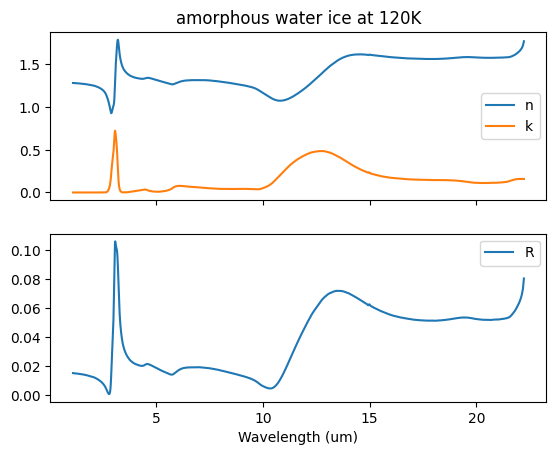

In [27]:
amorwater_nk.get_nk(122).plot_nk()

Now we can calculate a reflectance spectrum for a planetary surface using the slab approxmiation from Hapke. 

Most of the intricacies here are hidden within the HapkeModel.calculate_reflectance method, but we generally follow the prescription described in chapter ?? of the Hapke book.

A few important things to note:
- To calculate the single scattering albedo, we do not use the approximations described by Hapke for specific particle size regimes (see chapter 5.4) to estimate the scattering and extinction efficiencies, and instead exactly solve the Mie equations. THis is really only important if we care about reflections (aka Fresnell peaks)! These approximations were necessary because explicitly solving for the extinction and scattering coefficients was not tractable at the time, however today it is as easy as "pip install miepython"!
- We need to know the surface reflections (Se) and internal scattering (Si). Hapke has approximations for these, but they are only really good for n<1.2 which is not water ice. We instead integrate the Fresnell equations and directly solve equation 5.36.

In [28]:
model = HapkeModel(cryswater_nk)

Text(0, 0.5, 'Single scattering albedo')

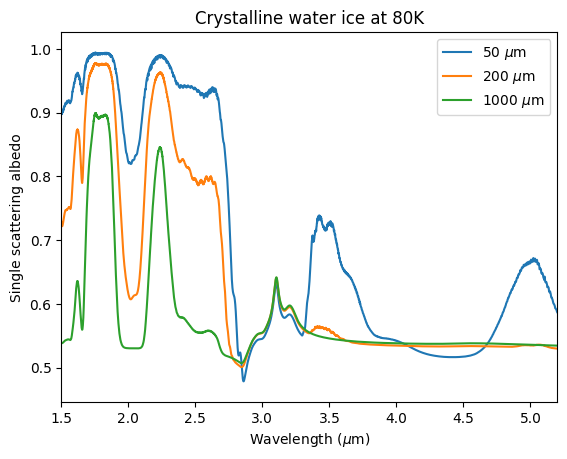

In [22]:
import matplotlib.pyplot as plt
waves = model.material.get_nk(80).wv

for grainsz in [50, 200, 1000]:
    plt.plot(waves, model.get_single_scattering_albedo(80, grainsz), label=fr"{grainsz} $\mu$m")

plt.xlim(1.5,5.2)
plt.legend()
plt.title(r'Crystalline water ice at 80K')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Single scattering albedo')


In [30]:
nk = model.material.get_nk(80)
n, k = nk.n, nk.k

In [33]:
# Mike's Se
def Se(n,k):
    theta=np.arange(0,89,1)*np.pi/180
    F1=np.sqrt(.5*((n*n-k*k-np.sin(theta)**2)+np.sqrt((n*n-k*k-np.sin(theta)**2)**2+4*n*n*k*k)))
    F2=np.sqrt(.5*(-(n*n-k*k-np.sin(theta)**2)+np.sqrt((n*n-k*k-np.sin(theta)**2)**2+4*n*n*k*k)))
    
    Rperp=((np.cos(theta)-F1)**2+F2**2)/((np.cos(theta)+F1)**2+F2**2)
           
    r1=((n**2-k**2)*np.cos(theta)-F1)**2+(2*n*k*np.cos(theta)-F2)**2
    r2=((n**2-k**2)*np.cos(theta)+F1)**2+(2*n*k*np.cos(theta)+F2)**2
           
    Rpar=r1/r2

    
    re=(Rperp+Rpar)*np.cos(theta)*np.sin(theta)
    
    s=np.sum(re)*np.pi/180
  
    
    return(s)

In [54]:
import scipy.integrate as integrate
def _Se(n,k):
    def F1(theta):
        return np.sqrt(.5*((n*n-k*k-np.sin(theta)**2)+np.sqrt((n*n-k*k-np.sin(theta)**2)**2+4*n*n*k*k)))
    def F2(theta):
        return np.sqrt(.5*(-(n*n-k*k-np.sin(theta)**2)+np.sqrt((n*n-k*k-np.sin(theta)**2)**2+4*n*n*k*k)))
    def Rperp(theta):
        return ((np.cos(theta)-F1(theta))**2+F2(theta)**2)/((np.cos(theta)+F1(theta))**2+F2(theta)**2)
    def Rpar(theta):
        r1=((n**2-k**2)*np.cos(theta)-F1(theta))**2+(2*n*k*np.cos(theta)-F2(theta))**2
        r2=((n**2-k**2)*np.cos(theta)+F1(theta))**2+(2*n*k*np.cos(theta)+F2(theta))**2
        return r1/r2
    def re(theta):
        return ((Rperp(theta)+Rpar(theta))*np.cos(theta)*np.sin(theta))#*np.pi/180
            
    s = integrate.quad(re, 0, np.pi/2) # integrate over 0 to pi/2
    return s[0]

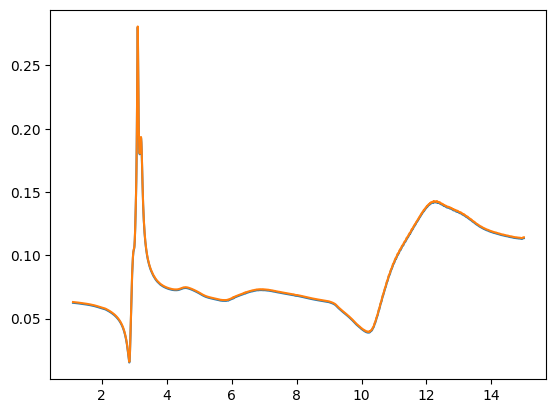

In [55]:
plt.plot(waves, [Se(n[i],k[i]) for i in range(len(waves))])
plt.plot(waves, [_Se(n[i],k[i]) for i in range(len(waves))])